In [145]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

df = pd.read_csv('G:\diva\EP-research\Maarten Fleur\ECG features_for_manuscript\COMBINED\clinical_ts_fresh_final.csv', index_col=0)
df.drop(['StudyID_x', 'ID'], axis=1, inplace=True)

ts_fresh_ = df.iloc[: , -9396:]

#Make all labels
y_mortality_5y = df['Mortality5Y']
y_mortality_4y= df['Mortality4Y']
y_mortality_3y= df['Mortality3Y']
y_mortality_2y= df['Mortality2Y']
y_mortality_1y= df['Mortality1Y']

y_nb_5y = df['ICDnonbenefit_5Y']
y_nb_4y = df['ICDnonbenefit_4Y']
y_nb_3y = df['ICDnonbenefit_3Y']
y_nb_2y = df['ICDnonbenefit_2Y']
y_nb_1y = df['ICDnonbenefit_1Y']

y_at_5y = df['AppropriateTherapy5Y']
y_at_4y = df['AppropriateTherapy4Y']
y_at_3y = df['AppropriateTherapy3Y']
y_at_2y = df['AppropriateTherapy2Y']
y_at_1y = df['AppropriateTherapy1Y']

#Pick label to train on
y = y_nb_1y

#All labels in one df
labels = ['Python_ID_Index','AppropriateTherapy1Y', 'AppropriateTherapy2Y', 'AppropriateTherapy3Y', 'AppropriateTherapy4Y', 'AppropriateTherapy5Y',
         'ICDnonbenefit_1Y', 'ICDnonbenefit_2Y', 'ICDnonbenefit_3Y', 'ICDnonbenefit_4Y', 'ICDnonbenefit_5Y',
         'Mortality1Y', 'Mortality2Y', 'Mortality3Y', 'Mortality4Y', 'Mortality5Y']
y_all_labels = df[labels]
#y_all_labels.to_csv('G:\diva\EP-research\Maarten Fleur\ECG features_for_manuscript\COMBINED\y_all_labels.csv')

#Select variables and assign these to a clinical set
var = ['Sex', 'AtrialArrhythmia', 'LowLVEF', 'ReducedLVEF', 'NormalLVEF', 'OHCA', 'ICM', 'NICM', 'HCM', 'DCM', 'PAS',
'PCI', 'CABG', 'MyocardialInfarction', 'VF', 'NSVT','SustVT', 'CVA','COPD', 'DiabetesMellitus', 'PAF', 'Hypertension', 
'CHD', 'Dyslipedaemia', 'VR', 'DR', 'CRTD', 'SICD', 'Vitamine_K', 'Antiaritmica_soort#Sotalol', 'Antiaritmica_soort#Digoxine', 
'Antiaritmica_soort#Amiodarone', 'Betablokker', 'NOAC', 'Aldosteronremmer', 'Implantation_indication', 'Age_normalised', 
'BMI_normalised', 'Sodium_normalised', 'Potassium_normalised', 'Kreatinine_normalised', 'QRS_Duration_normalised']

identifier = ['Python_ID_Index']

identifier = df[identifier]
df = df[var]

#Convert columns to categorical for missForsts
var_bin = ['Sex', 'AtrialArrhythmia', 'LowLVEF', 'ReducedLVEF', 'NormalLVEF', 'OHCA', 'ICM', 'NICM', 'HCM', 'DCM', 'PAS',
'PCI', 'CABG', 'MyocardialInfarction', 'VF', 'NSVT','SustVT', 'CVA','COPD', 'DiabetesMellitus', 'PAF', 'Hypertension', 
'CHD', 'Dyslipedaemia', 'VR', 'DR', 'CRTD', 'SICD', 'Vitamine_K', 'Antiaritmica_soort#Sotalol', 'Antiaritmica_soort#Digoxine', 
'Antiaritmica_soort#Amiodarone', 'Betablokker', 'NOAC', 'Aldosteronremmer', 'Implantation_indication']

df[var_bin] = df[var_bin].astype('category')
X_clinical = df
catColumnsPos = [X_clinical.columns.get_loc(col) for col in list(X_clinical.select_dtypes('category').columns)]

# Make an instance and perform the imputation
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
imputer = MissForest()
X_imputed = imputer.fit_transform(X_clinical, cat_vars=catColumnsPos)
X_imputed = pd.DataFrame(X_imputed, columns=X_clinical.columns)

#Extract relevant features
from tsfresh import extract_features, select_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

#Get relevance table
relevance_table = calculate_relevance_table(ts_fresh_, y)

#Extract top 600 features based on relavence table
top250 = relevance_table.iloc[:250,:]
input = top250['feature']
print(input.shape)
list_of_relevantfeatures = (list(input))
features_filtered = ts_fresh_[list_of_relevantfeatures]

#Scaling data ECG
scaling_set = features_filtered
features_mean = scaling_set.mean()
features_std = scaling_set.std()
scaling_set=((scaling_set-features_mean)/features_std)

#Drop high correlating variables
def drop_input_corr_columns(x_features, corr_fac = 0.90):
    # Create correlation matrix
    corr_matrix = x_features.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than corr_fac
    to_drop = [column for column in upper.columns if any(upper[column] > corr_fac)]
    # Drop features 
    x_features_no_colnr = x_features.drop(columns = to_drop) 
    return x_features_no_colnr, to_drop
  
#drop all but one features with correlation of 0.9 or more ECG
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

features_filtered_no_colnr, to_drop = drop_input_corr_columns(scaling_set, corr_fac = 0.9)
ts_fresh = features_filtered_no_colnr.dropna(axis='columns')

#L1 LogisticRegression
from sklearn.linear_model import LogisticRegression
features_filtered_no_colnr_norm = ts_fresh
log_reg = LogisticRegression(penalty='l1', random_state = 1201, solver='liblinear',
                             multi_class = 'ovr', C = 0.01, max_iter = 1000).fit(features_filtered_no_colnr_norm, y)
numberOfFeatures = 200
logReg_coef = log_reg.coef_
topFeaturesIdx = np.argsort(np.abs(logReg_coef[0,:]))[-numberOfFeatures:]
#print("The most relevant features:", features_filtered_no_colnr_norm.columns[topFeaturesIdx])
ecg_rem =features_filtered_no_colnr_norm.columns[topFeaturesIdx]
features_filtered_no_colnr_norm_L1 = features_filtered_no_colnr_norm.iloc[:,topFeaturesIdx]
X = features_filtered_no_colnr_norm_L1

#Join the ECG features and imputed clinical information
X = X.join(X_imputed)

#Use DEEP RISK as external cohort
X_with_identifier = X.join(identifier)
y = pd.DataFrame(y)
y = y.join(identifier)

#Use DEEP RISK as external cohort
def External_cohort(dfObj):
    if (dfObj['Python_ID_Index'] < 1798):
        return '1' #DISTANT
    elif (dfObj['Python_ID_Index'] > 1797):
        return '0' #DEEPRISK
X['Python_ID_Index'] = X_with_identifier.apply(External_cohort, axis = 1)
X['Python_ID_Index'] = X['Python_ID_Index'].astype(str).astype(int)
X_train = X[X["Python_ID_Index"] == 1]
X_train.drop(['Python_ID_Index'], axis=1, inplace=True)

X_test = X[X["Python_ID_Index"] == 0]
X_test.drop(['Python_ID_Index'], axis=1, inplace=True)

y['Python_ID_Index'] = y.apply(External_cohort, axis = 1)
y['Python_ID_Index'] = y['Python_ID_Index'].astype(str).astype(int)
y_train = y[y["Python_ID_Index"] == 1]
y_train.drop(['Python_ID_Index'], axis=1, inplace=True)

y_test = y[y["Python_ID_Index"] == 0]
y_test.drop(['Python_ID_Index'], axis=1, inplace=True)

# from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.25, random_state=3, stratify=y)
# cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=10)

print(X_train.shape)
print(X_test.shape)

C:\Users\mzkolk\AppData\Local\Temp/ipykernel_5940/4048708135.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('G:\diva\EP-research\Maarten Fleur\ECG features_for_manuscript\COMBINED\clinical_ts_fresh_final.csv', index_col=0)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
(250,)
(875, 242)
(687, 242)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc, RocCurveDisplay, precision_recall_curve
from sklearn import metrics
import matplotlib.pyplot as plt
from numpy import interp
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import cross_validate
import pprint 

def draw_cv_roc_curve(classifier, cv, X, y, title='ROC Curve'):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])              
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        #plt.plot(fpr, tpr, lw=1, alpha=0.3,
        #         label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='grey',
             label=None)    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='darkolivegreen', label=r'Mean ROC (AUC=%0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def draw_cv_pr_curve(classifier, cv, X, y, title='PR Curve'):
    prs = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        pr, re, thresholds  = precision_recall_curve(y.iloc[test], probas_[:, 1])     
        prs.append(interp(mean_recall, pr, re))
        #prs[-1][0] = 0.0
        pr_auc = metrics.auc(re, pr)
        aucs.append(pr_auc)    
        # Plotting each individual PR Curve
       # plt.plot(re, pr, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))
        i += 1
   # plt.plot([0, 1], [1, 0], linestyle='--', lw=3, color='k', label=None, alpha=.8)
    mean_precision = np.mean(prs, axis=0)
    #mean_precision[-1] = 1.0
    mean_auc = metrics.auc(mean_recall, mean_precision)
    std_auc = np.std(aucs)
    plt.plot(mean_recall, mean_precision, color='b', label=r'Precision-Recall (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2,alpha=.8)
    std_prs = np.std(prs, axis=0)
    tprs_upper = np.minimum(mean_precision + std_prs, 1)
    tprs_lower = np.maximum(mean_precision - std_prs, 0)
    plt.fill_between(mean_recall, tprs_lower, tprs_upper, color='grey', alpha=.4, label=r'$\pm$ 1 Standard Deviation')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
        
def sensivity_specifity_cutoff(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]
def recall_cutoff(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    fscore = (2 * precision * recall) / (precision + recall)
    idx = np.argmax(fscore)
    return thresholds[idx]  
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1]}
def cross_validation(model, _X, _y, _cv=cv):
    _scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'neg_brier_score']
    results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)     
    return {"Mean Validation Accuracy": results['test_accuracy'].mean()*100,
            "Mean Validation Precision": results['test_precision'].mean(),
            "Mean Validation Recall": results['test_recall'].mean(),
            "Mean Validation F1 Score": results['test_f1'].mean(),
            "Mean ROC": results['test_roc_auc'].mean(),
            "Brier": results['test_neg_brier_score'].mean(),
            "Balanced accuracy": results['test_balanced_accuracy'].mean()}        

# %matplotlib inline
#Hyperparameter tuning SVM
SVM = svm.SVC(probability=True)
random_grid = {'C': [0.01, 0.1,1,5,10,100,200,500], 'gamma': [10,1,0.1,0.075,0.05,0.01,0.001,0.005,0.0001],'kernel': ['rbf', 'poly', 'sigmoid']}
svm_random = GridSearchCV(estimator = SVM, scoring="roc_auc", param_grid = random_grid, cv = 5, verbose=3, n_jobs = 1)
svm_random.fit(X_train, y_train)
SVC = svm_random.best_estimator_
print(svm_random.best_params_)
model = SVC

# #Hyperparameter tuning XGboost
# classifier = xgb.XGBClassifier()
# params = {'learning_rate': [0.05,0.10,0.20], 'max_depth': [3,6,9,12], 
# 'min_child_weight': [1, 3, 5, 7], 'gamma': [0.0,0.2,0.4], 'colsample_bytree': [0.3,0.5,0.7]}
# xgb_random=GridSearchCV(classifier,param_grid=params, scoring='roc_auc',n_jobs=1,cv=5,verbose=3)
# xgb_random.fit(X_train,y_train)
# xgb = xgb_random.best_estimator_
# model = xgb

# #Cross-validation
# lr_cv = cross_validation(model, X_train, y_train, cv)
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(lr_cv)

#ROC curve
plt.figure(dpi=150)
draw_cv_roc_curve(model, cv, X_train, y_train, title='Repeated K-fold Cross Validated ROC')

#PR curve
plt.figure(dpi=150)
draw_cv_pr_curve(model, cv, X_train, y_train, title='Repeated K-fold Cross Validated PR')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END ......C=0.01, gamma=10, kernel=rbf;, score=0.500 total time=   0.1s
[CV 2/5] END ......C=0.01, gamma=10, kernel=rbf;, score=0.500 total time=   0.1s
[CV 3/5] END ......C=0.01, gamma=10, kernel=rbf;, score=0.500 total time=   0.1s
[CV 4/5] END ......C=0.01, gamma=10, kernel=rbf;, score=0.500 total time=   0.1s
[CV 5/5] END ......C=0.01, gamma=10, kernel=rbf;, score=0.500 total time=   0.1s
[CV 1/5] END .....C=0.01, gamma=10, kernel=poly;, score=0.673 total time=   0.1s
[CV 2/5] END .....C=0.01, gamma=10, kernel=poly;, score=0.773 total time=   0.1s
[CV 3/5] END .....C=0.01, gamma=10, kernel=poly;, score=0.685 total time=   0.1s
[CV 4/5] END .....C=0.01, gamma=10, kernel=poly;, score=0.751 total time=   0.1s
[CV 5/5] END .....C=0.01, gamma=10, kernel=poly;, score=0.954 total time=   0.1s
[CV 1/5] END ..C=0.01, gamma=10, kernel=sigmoid;, score=0.768 total time=   0.0s
[CV 2/5] END ..C=0.01, gamma=10, kernel=sigmo

In [143]:
print(svm_random.best_params_)

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


C:\Users\mzkolk\AppData\Local\Temp/ipykernel_5940/1003681670.py:89: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


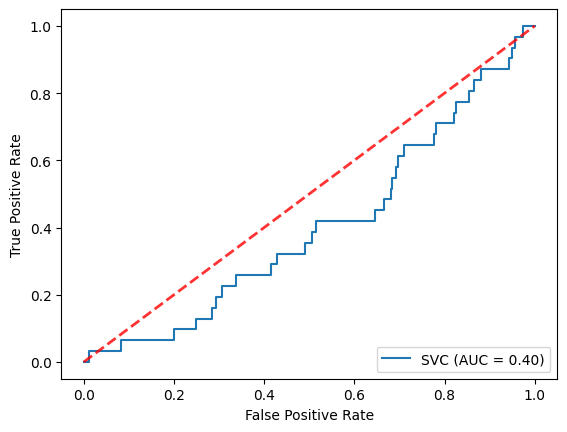

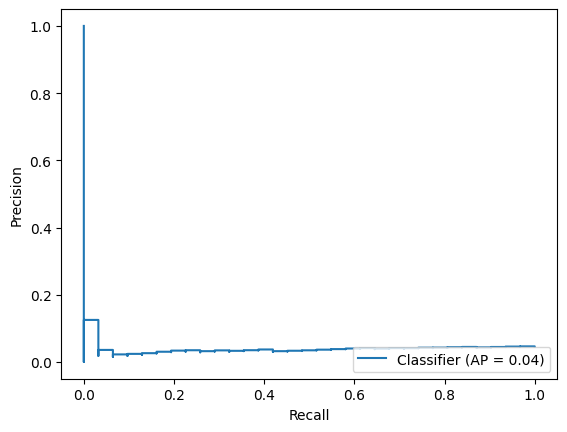

In [144]:
from sklearn.metrics import PrecisionRecallDisplay, accuracy_score, auc, average_precision_score, ConfusionMatrixDisplay, confusion_matrix, roc_curve, precision_recall_curve

#Get probabilities
model = model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:, 1]
youden_index = ((sensivity_specifity_cutoff(y_test, y_prob)))
recall_index = ((recall_cutoff(y_test, y_prob)))
#print('Youden index:', youden_index)
#print('Recall index:', recall_index)
y_pred = model.predict_proba(X_test)[:, 1] >= youden_index

#ROC
metrics.plot_roc_curve(model, X_test, y_test) 
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label=None, alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#PR
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.show()